<a href="https://colab.research.google.com/github/mjsonu/Fellowship/blob/main/fellowship.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To make Flower dataset folder

In [ ]:
import tarfile
import os

# Path to the 102flowers.tgz file
tar_file_path = '102flowers.tgz'
extracted_dir = 'flowers_dataset\splitlowers_dataset\split'

# Extract the tar file
with tarfile.open(tar_file_path, 'r:gz') as tar:
    tar.extractall(path=extracted_dir)

print(f"Images extracted to {extracted_dir}")


Images extracted to flowers_dataset\splitlowers_dataset\split


Organizing the data into test , train and valid folder

In [ ]:
import scipy.io
import numpy as np
import os
import shutil



# Path to the imagelabels.mat file
labels_file_path = '/content/imagelabels.mat'

# Load the labels
labels_data = scipy.io.loadmat(labels_file_path)
labels = labels_data['labels'][0]  # Extract the labels (1D array)

# Check label information
print(f"Number of images: {len(labels)}")
print(f"Unique labels: {np.unique(labels)}")




## NEXT PART OF OGANISING IN TRAIN TEST AND VALIDATE


# Load the dataset splits
setid_file_path = '/content/setid.mat'
setid_data = scipy.io.loadmat(setid_file_path)

train_ids = setid_data['trnid'][0]  # Training IDs
val_ids = setid_data['valid'][0]    # Validation IDs
test_ids = setid_data['tstid'][0]   # Test IDs

# Function to move images to their respective folders

def move_images(image_ids, dataset_type, labels, source_dir, target_dir):
    for image_id in image_ids:
        label = labels[image_id - 1]  # Labels are 1-indexed
        label_dir = os.path.join(target_dir, dataset_type, f'class_{label}')
        os.makedirs(label_dir, exist_ok=True)

        # Source image path
        image_file = os.path.join(source_dir, f'image_{image_id:05d}.jpg')

        # Move the image to the target directory
        shutil.copy(image_file, label_dir)

# Paths to organize dataset
source_images_dir ='/content/flowers_dataset\splitlowers_dataset\split/jpg'
target_dir = '/content/flowers_dataset\splitlowers_dataset\split'

# Move images to train, val, and test folders
move_images(train_ids, 'train', labels, source_images_dir, target_dir)
move_images(val_ids, 'val', labels, source_images_dir, target_dir)
move_images(test_ids, 'test', labels, source_images_dir, target_dir)

print("Dataset organized for training!")

Number of images: 8189
Unique labels: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102]
Dataset organized for training!


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# Define transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Load datasets
data_dir = '/content/flowers_dataset\splitlowers_dataset\split'
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val'])
}

# DataLoader
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True),
    'val': DataLoader(image_datasets['val'], batch_size=32, shuffle=False)
}


Traning the model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image



# Define transformations before using them
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Set up paths
data_dir = '/content/flowers_dataset\splitlowers_dataset\split'  # Adjust this path to your Google Drive location

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained ResNet-50 model with weights
model_ft = models.resnet50(weights='DEFAULT')  # Use weights argument

# Modify the fully connected layer for 102 classes
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 102)  # 102 flower categories

# Move model to GPU if available
model_ft = model_ft.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Define the function to train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Initialize a history dictionary to store loss and accuracy values for plotting
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Store the loss and accuracy for this epoch
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            # Save the best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Return the model and the training history
    return model, history

# Load datasets
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val'])
}

# DataLoader
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True),
    'val': DataLoader(image_datasets['val'], batch_size=32, shuffle=False)
}

# Model, criterion, optimizer, etc.
model_ft = models.resnet50(weights='DEFAULT')  # Load the model with weights
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 102)  # 102 flower categories
model_ft = model_ft.to(device)  # Move model to device

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train the model
model_ft, history = train_model(model_ft, criterion, optimizer_ft, scheduler, num_epochs=100)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0/99
----------
train Loss: 4.1668 Acc: 0.1059
val Loss: 4.7664 Acc: 0.1784
Epoch 1/99
----------
train Loss: 2.2609 Acc: 0.4471
val Loss: 1.7582 Acc: 0.5520
Epoch 2/99
----------
train Loss: 1.3561 Acc: 0.6422
val Loss: 1.4122 Acc: 0.6294
Epoch 3/99
----------
train Loss: 1.0161 Acc: 0.7186
val Loss: 1.2650 Acc: 0.6843
Epoch 4/99
----------
train Loss: 0.7366 Acc: 0.8010
val Loss: 1.2109 Acc: 0.7098
Epoch 5/99
----------
train Loss: 0.6800 Acc: 0.8255
val Loss: 6.0218 Acc: 0.6363
Epoch 6/99
----------
train Loss: 0.5622 Acc: 0.8578
val Loss: 0.8099 Acc: 0.7961
Epoch 7/99
----------
train Loss: 0.3954 Acc: 0.8951
val Loss: 0.5301 Acc: 0.8667
Epoch 8/99
----------
train Loss: 0.2436 Acc: 0.9441
val Loss: 0.4764 Acc: 0.8794
Epoch 9/99
----------
train Loss: 0.2057 Acc: 0.9529
val Loss: 0.4378 Acc: 0.8853
Epoch 10/99
----------
train Loss: 0.1484 Acc: 0.9667
val Loss: 0.4194 Acc: 0.8990
Epoch 11/99
----------
train Loss: 0.1535 Acc: 0.9696
val Loss: 0.4206 Acc: 0.9010
Epoch 12/99
--

In [ ]:
torch.save(model_ft.state_dict(), 'flower_resnet50.pth')



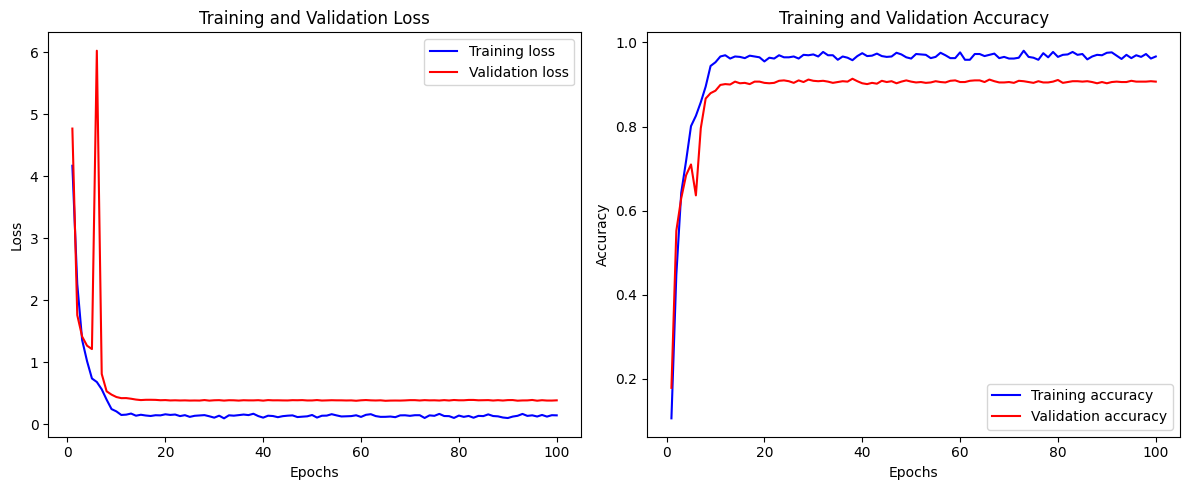

In [ ]:
def plot_training_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Plot Loss curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b', label='Training loss')
    plt.plot(epochs, history['val_loss'], 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b', label='Training accuracy')
    plt.plot(epochs, history['val_acc'], 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plot function after training is complete
plot_training_curves(history)


To test the model

In [ ]:
def predict_flower(image_path, model):
    model.eval()
    image = Image.open(image_path)


    image = data_transforms['val'](image).unsqueeze(0)
    image = image.to(device)

    outputs = model(image)
    _, preds = torch.max(outputs, 1)

    return class_names[preds]

# Load and predict
model_ft.load_state_dict(torch.load('/content/flower_resnet50.pth'))
image_path = '/content/flowers_dataset\splitflowers_dataset\split/test/class_75/image_02070.jpg'
#image_path = '/content/flowers_dataset\splitflowers_dataset\split/test/class_16/image_06684.jpg'
predicted_class = predict_flower(image_path, model_ft)
print(f'The predicted flower category is: {predicted_class}')